In [1]:
import pickle

import torch
from torchvision.transforms import v2 as transforms

import numpy as np
from ultralytics import YOLO

from keyrover import *
from keyrover.datasets import *
from keyrover.vision import *
from keyrover.color import image_color
from keyrover.ml import get_device, TexCoordsRegressionModel

2024-11-08 17:56:13.977 Python[41323:8132626] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


In [2]:
device = get_device()

In [3]:
mean, std = get_dataset_norm_params(version=3)
norm = transforms.Normalize(mean, std)

SIZE = (256, 256)

transform = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize(SIZE),
    transforms.ToDtype(torch.float32, scale=True),
    norm,
])

In [4]:
with open(f"{RAW_TEXCOORDS}/key_texcoords_mean.bin", "rb") as file:
    U_means = pickle.load(file)
    V_means = pickle.load(file)

palette = []
palette_to_id = {}

for (cls, u), (_, v) in zip(U_means.items(), V_means.items()):
    palette.append([u, v])
    palette_to_id[(u, v)] = cls

palette = np.array(palette)

In [5]:
ARCH = "unet"
BACKBONE = "timm-regnetx_004"
name = "brisk-plant-1"

model = TexCoordsRegressionModel(ARCH, BACKBONE, in_channels=3, out_classes=2, lr=0.0, activation="tanh")
model.load_state_dict(torch.load(f"models/texcoords/{name}-{ARCH}-{BACKBONE}.pt", weights_only=True))
model.to(device)
model.eval()

yolo = YOLO("models/yolo/train4/weights/best.pt")


0: 320x320 79 keys, 21.9ms
Speed: 1.6ms preprocess, 21.9ms inference, 0.5ms postprocess per image at shape (1, 3, 320, 320)


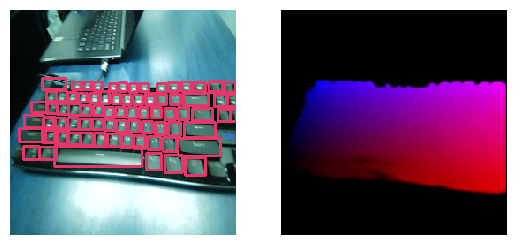

In [6]:
img = cv2.imread(f"{TEST_DATASET}/8.jpg")
img = cv2.resize(img, SIZE)
pred = yolo.predict(img, conf=0.25)[0]
keyboard_mask = model.predict(transform(img))

keyboard_mask = img_to_numpy(keyboard_mask) + 1
r, g = keyboard_mask
black = np.zeros(r.shape, dtype=keyboard_mask.dtype)
keyboard_mask = cv2.merge([r, black, g])

out = plot_yolo(pred, scale=1, draw_text=False, plot=False)

imshow(out, keyboard_mask)

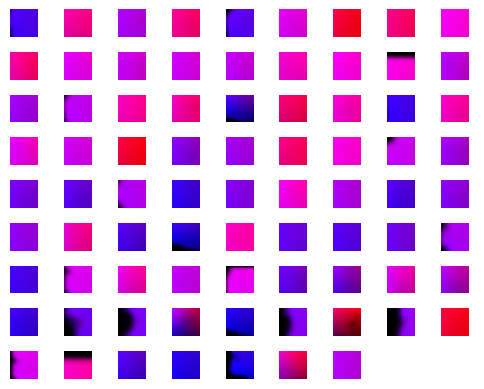

In [7]:
import numpy as np

keys = []
colors = []

img = pred.orig_img

for box in pred.boxes:
    x1, y1, x2, y2 = box.xyxy[0]
    rect = np.array([(x1, y1), (x2, y1), (x2, y2), (x1, y2)], dtype="int")

    crop = crop_rect(keyboard_mask, rect)
    crop = cv2.resize(crop, (64, 64))
    crop *= 127
    color = image_color(crop)
    
    if color is None:
        continue
    
    keys.append(crop)
    colors.append(color[[0, -1]])

show_images(keys, figsize=(5, 4))

In [8]:
colors = np.array(colors)
colors = to_palette(colors, palette)

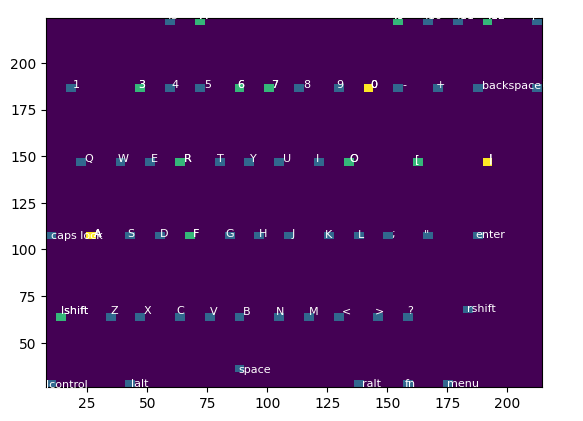

In [9]:
ax = plt.gca()
labels = []

for color in colors:
    id_ = palette_to_id[tuple(color)]
    label = id_to_key.get(id_, str(id_))
    labels.append(label)
    ax.text(U_means[id_], V_means[id_], label, c="white", fontsize=8)
    # ax.scatter(color[0], color[1], s=20, c=(255, 255, 255))

ax.hist2d(*to_palette(colors, palette).T, bins=50)
plt.show()

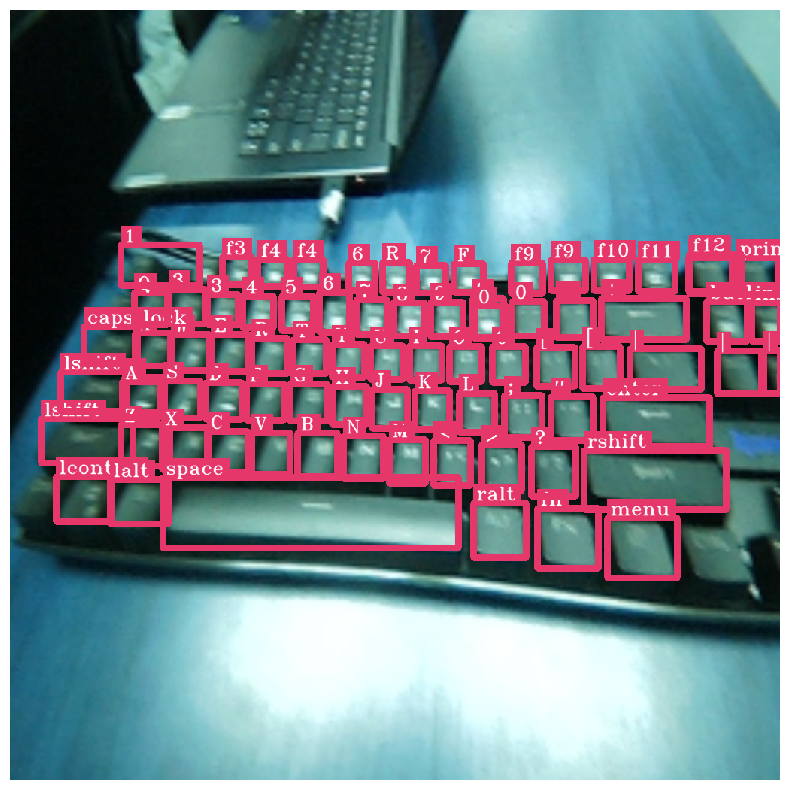

In [11]:
plot_predictions(pred.orig_img, pred.boxes, labels, figsize=(10, 10))